# Time Series Forecast with Basic LSTM and GRU 

In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/pm25.csv')

print(df.shape)
df.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(year=row['year'], 
                                  month=row['month'], day=row['day'],hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)  
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
df_val.reset_index(drop=True, inplace=True)
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (33096, 15)
Shape of test: (8661, 15)


In [4]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [5]:
X_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
X_val, y_val = makeXy(df_val['scaled_pm2.5'], 7)

print('Shape of train arrays:', X_train.shape, y_train.shape)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of train arrays: (33089, 7) (33089,)
Shape of validation arrays: (8654, 7) (8654,)


In [6]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (33089, 7, 1) (8654, 7, 1)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_error

tf.random.set_seed(10)

## LSTM

In [18]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1:])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [19]:
save_weights_at = 'basic_lstm_model'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq=1)
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 25s 10ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0133 - val_mae: 0.0133ss: 0.0276 - ETA: 2 - ETA: 1s -  - ETA: 0s - loss: 0.0264 -


INFO:tensorflow:Assets written to: basic_lstm_model\assets


INFO:tensorflow:Assets written to: basic_lstm_model\assets


Epoch 2/20
2069/2069 [==============================] - 27s 13ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0138 - val_mae: 0.0138 3s - loss: 0.0153 - - ETA: 2s - loss: 0.0153  - ETA: 1s - loss: 0.0153 - mae: - ETA: 1s - loss: 0.0 - ETA: 0s - loss: 0.0153 - 
Epoch 3/20
2069/2069 [==============================] - 26s 12ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 4/20
2069/2069 [==============================] - 25s 12ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0149 - val_mae: 0.0149.0148 - mae:
Epoch 5/20
2069/2069 [==============================] - 23s 11ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0118 - val_mae: 0.0118


INFO:tensorflow:Assets written to: basic_lstm_model\assets


INFO:tensorflow:Assets written to: basic_lstm_model\assets


Epoch 6/20
2069/2069 [==============================] - 17s 8ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 7/20
2069/2069 [==============================] - 17s 8ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 8/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 9/20
2069/2069 [==============================] - 25s 12ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 10/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 11/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 12/20
2069/2069 [==============================] - 22s 11ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 13/20
2069/2069 [=========================

In [22]:
# load the best model
best_model = load_model('basic_lstm_model')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

MAE for the validation set: 11.7606
MAE for the scaled validation set: 0.0118


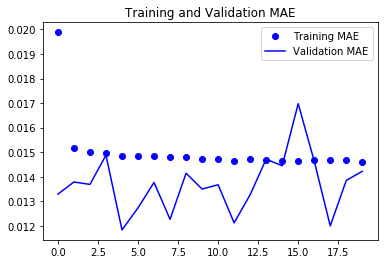

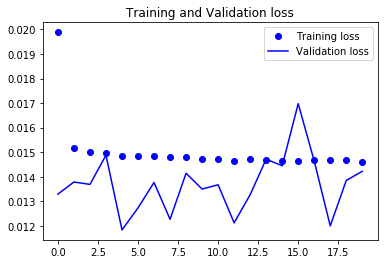

In [23]:
# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## GRU

In [24]:
model = Sequential()
model.add(GRU(32, input_shape=(X_train.shape[1:])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [25]:
save_weights_at = 'basic_gru_model'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq=1)
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 26s 10ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0188 - val_mae: 0.0188


INFO:tensorflow:Assets written to: basic_gru_model\assets


INFO:tensorflow:Assets written to: basic_gru_model\assets


Epoch 2/20
2069/2069 [==============================] - 20s 9ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0141 - val_mae: 0.0141


INFO:tensorflow:Assets written to: basic_gru_model\assets


INFO:tensorflow:Assets written to: basic_gru_model\assets


Epoch 3/20
2069/2069 [==============================] - 19s 9ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 4/20
2069/2069 [==============================] - 27s 13ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0133 - val_mae: 0.0133


INFO:tensorflow:Assets written to: basic_gru_model\assets


INFO:tensorflow:Assets written to: basic_gru_model\assets


Epoch 5/20
2069/2069 [==============================] - 19s 9ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 6/20
2069/2069 [==============================] - 20s 9ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 7/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 8/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 9/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 10/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 11/20
2069/2069 [==============================] - 21s 10ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0121 - val_mae: 0.0121


INFO:tensorflow:Assets written to: basic_gru_model\assets


INFO:tensorflow:Assets written to: basic_gru_model\assets


Epoch 12/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 13/20
2069/2069 [==============================] - 19s 9ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 14/20
2069/2069 [==============================] - 22s 10ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 15/20
2069/2069 [==============================] - 26s 12ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0159 - val_mae: 0.0159
Epoch 16/20
2069/2069 [==============================] - 29s 14ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 17/20
2069/2069 [==============================] - 28s 13ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 18/20
2069/2069 [==============================] - 26s 13ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 19/20
2069/2069 [===================

In [26]:
# load the best model
best_model = load_model('basic_gru_model')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

MAE for the validation set: 12.0311
MAE for the scaled validation set: 0.0121


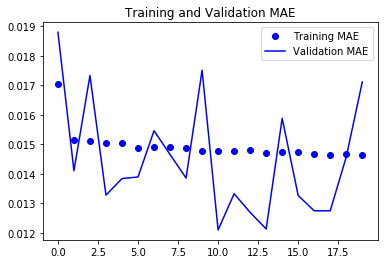

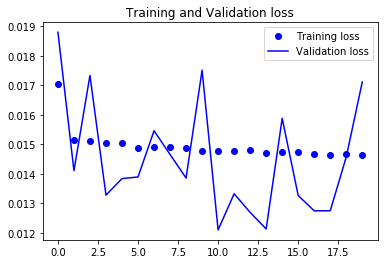

In [27]:
# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()